In [1]:
import numpy as np

In [2]:
# Abro el archivo con el que voy a entrenar el modelo
# Mohr-Smith_2017_Completa.csv

from google.colab import files

uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [0]:
# Importo el archivo como dataset

import io
import pandas as pd

df0= pd.read_csv(io.BytesIO(uploaded['Mohr-Smith_2017_Completa.csv']))

In [0]:
"""
Elegimos las columnas del archivo con las que vamos a trabajar

-----IMPORTANTE------

Las columnas de las magnitudes deben estar acomodadas del azul hacia el rojo
y ser el ultimo bloque de columnas
"""
column_names=['EM', 'SUB', 'LUM', 'umag', 'gmag', 'rmag', 'Hamag', 'imag', 'Jmag', 'Hmag', 'Kmag']


In [0]:
"""
Defino el sistema fotometrico de cada filtro

Para eso armo un diccionario donde la llave es el nombre de la columna del dataframe
y la defino con una lista [sistema fotometrico, nombre del filtro, lambda eff (en angtroms)]
"""

# Las $\lambda_{eff}$ de cada filtro las saqué de las páginas:

# VPHAS:
# http://svo2.cab.inta-csic.es/svo/theory//fps3/index.php?id=Paranal/OmegaCAM.Halp

# 2MASS:
# https://old.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html

foto_sys= {'umag': ['VPHAS', 'u', 3607.7],
           'gmag': ['VPHAS', 'g', 4679.5],
           'rmag': ['VPHAS', 'r', 6242.1],
           'imag': ['VPHAS', 'i', 7508.5],
           'Hamag': ['VPHAS', 'Ha', 6590.8],
           'Jmag': ['2MASS', 'J', 12350.0],
           'Hmag': ['2MASS', 'H', 16620.0],
           'Kmag': ['2MASS', 'K', 21590.0]}

In [10]:
"""
Calculo el coeficiente r = A_lambda / Av para cada filtro

Busco en la tabla de Schlafly & Finkbeiner(2011) primero por sistema y filtro.
Si no, por le lambda efeccitvo mas cercano.
"""

uploaded = files.upload()
Schlafly= pd.read_csv(io.BytesIO(uploaded['Schlafly2011.csv']))

Saving Schlafly2011.csv to Schlafly2011.csv


In [104]:
Rv= 3.1 # los valores tabulados son Rv= 2.1, 3.1, 4.1, 5.1

for key in foto_sys:

  # Me fijo si el sistema y el filtro estan en la tabla

  if foto_sys[key][0] in np.unique(Schlafly['System']) and foto_sys[key][1] in np.unique(Schlafly['Bandpass']):

    r= float(Schlafly['Rv_' + str(Rv)][Schlafly['System'] == foto_sys[key][0]][Schlafly['Bandpass'] == foto_sys[key][1]]  )
    foto_sys[key].append( r )

  # Si no, busco por el lambda efectivo mas cercano

  else:

    i= np.argmin( np.array( abs( foto_sys[key][2] - Schlafly['Lambda_eff'] ) ) )
    r= Schlafly['Rv_' + str(Rv)][i]
    foto_sys[key].append( r )

  print( foto_sys[key] )
 

['VPHAS', 'u', 3607.7, 4.239]
['VPHAS', 'g', 4679.5, 3.35]
['VPHAS', 'r', 6242.1, 2.3409999999999997]
['VPHAS', 'i', 7508.5, 1.6840000000000002]
['VPHAS', 'Ha', 6590.8, 2.055]
['2MASS', 'J', 12350.0, 0.726]
['2MASS', 'H', 16620.0, 0.449]
['2MASS', 'K', 21590.0, 0.302]


In [0]:
# Armo un dataframe solo con las columnas que me interesan

df= df0[column_names]

"""Elimino las filas que tienen valores NaN"""
df= df.dropna(subset=column_names)

In [106]:
"""
Armo la clasificacion:

        Estrellas con emision      -> EM = 1
        Estrellas Subluminosas     -> SUB = 1
        Estrellas Sobreluminosas   -> LUM = 1
"""

mask_EM= (df['EM'] == 1)
mask_SUB= (df['SUB'] == 1)
mask_LUM= (df['LUM'] == 1)

mask_OB_nor= (~mask_EM & ~mask_SUB & ~mask_LUM)
mask_OB_EM= (mask_EM & ~mask_SUB & ~mask_LUM)
mask_OB_SUB= (~mask_EM & mask_SUB & ~mask_LUM)
mask_OB_LUM= (~mask_EM & ~mask_SUB & mask_LUM)

df['Target']=np.nan
df['Target'][mask_OB_nor]=111
df['Target'][mask_OB_EM]=222
df['Target'][mask_OB_SUB]=333
df['Target'][mask_OB_LUM]=444
df= df.dropna(subset=column_names)

dic= {'111': 'OB', '222': 'EM', '333': 'SUB', '444': 'LUM'}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be s

In [0]:
"""
Calculo el parametro Q fotometrico:

Q= (m1 - m2) - (m2 - m3) * (r1 - r2) / (r2 - r3)

donde m1, m2, m3 son las magnitudes aparentes en tres filtros
      r1, r2, r3 son los coeficientes A_lambda / Av para cada filtro, respectivamente
"""

i= column_names.index('umag')
cols= column_names[i:]

for c in cols[:-2]:
  
  i= np.where(np.array(cols) == c)[0][0]
  r1= foto_sys[c][3]

  for cc in cols[i+1:-1]:

    j= np.where(np.array(cols) == cc)[0][0]
    r2= foto_sys[cc][3]

    aux= r1 - r2

    for ccc in cols[j+1:]:

      r3= foto_sys[ccc][3]

      coef= aux / (r2 - r3)

      df['Q_' + c + '_' + cc + '_' + ccc] = df[c] - df[cc] - coef * (df[cc] - df[ccc])
      #df['Q_' + cc + '_' + ccc + '_' + c] = df[cc] - df[ccc] - (df[c] - df[cc]) / coef

       

In [0]:
from google.colab import files

df.to_csv('zz.csv') 
files.download('zz.csv')

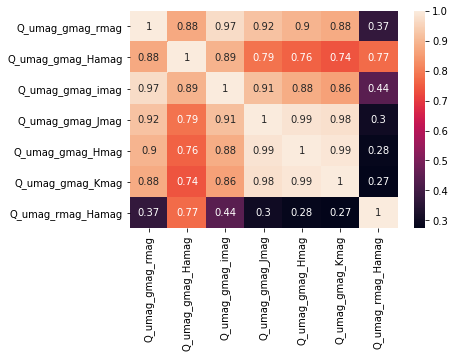

In [109]:
# Matriz de correlacion

import seaborn as sn

cols= df.columns.tolist()
i= cols.index('Q_umag_gmag_rmag')

corrMatrix = df[df.columns[i:i+7]].corr()
sn.heatmap(corrMatrix, annot=True)

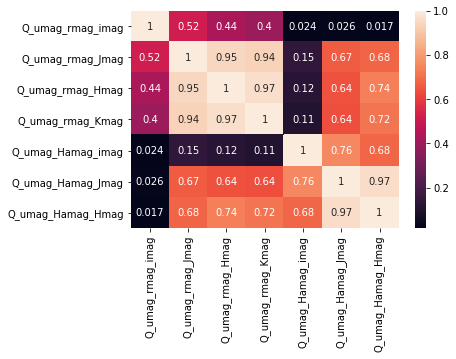

In [110]:
corrMatrix = df[df.columns[i+7:i+14]].corr()
sn.heatmap(corrMatrix, annot=True)


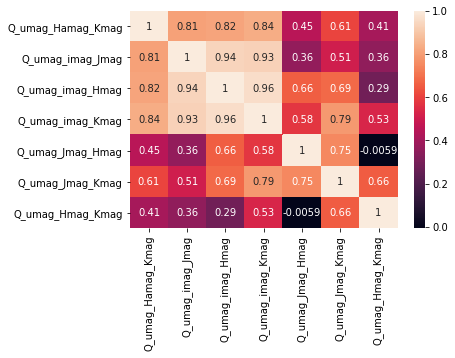

In [111]:
corrMatrix = df[df.columns[i+14:i+21]].corr()
sn.heatmap(corrMatrix, annot=True)


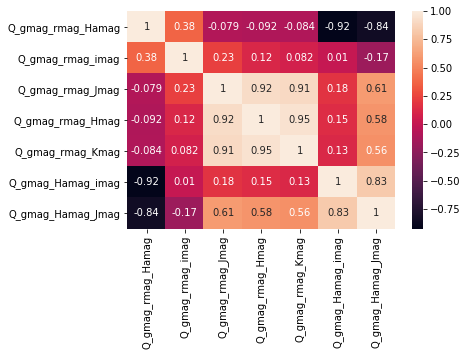

In [112]:
corrMatrix = df[df.columns[i+21:i+28]].corr()
sn.heatmap(corrMatrix, annot=True)


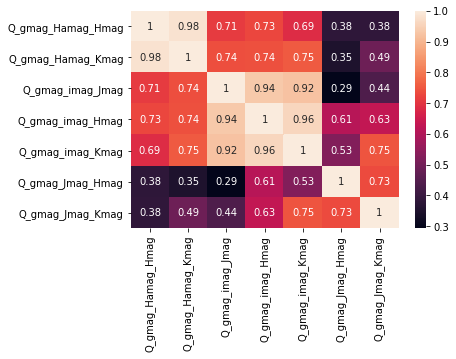

In [113]:
corrMatrix = df[df.columns[i+28:i+35]].corr()
sn.heatmap(corrMatrix, annot=True)


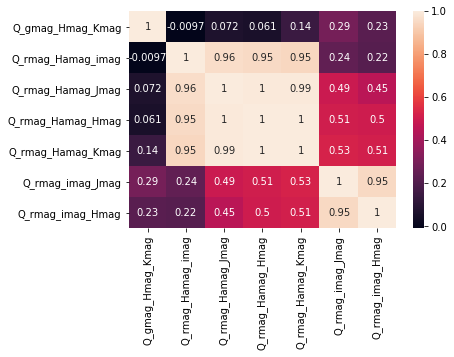

In [114]:
corrMatrix = df[df.columns[i+35:i+42]].corr()
sn.heatmap(corrMatrix, annot=True)


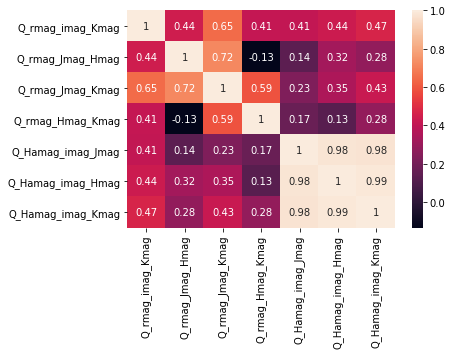

In [117]:
corrMatrix = df[df.columns[i+42:i+49]].corr()
sn.heatmap(corrMatrix, annot=True)


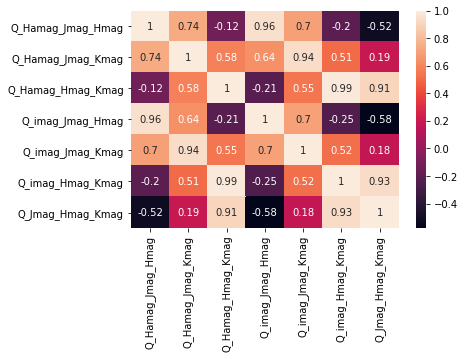

In [118]:
corrMatrix = df[df.columns[i+49:]].corr()
sn.heatmap(corrMatrix, annot=True)


In [0]:
# Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split

cols= df.columns.tolist()
i= cols.index('Q_umag_gmag_rmag')

X = df[df.columns[i:]].values
Y = df['Target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)


In [136]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.fit_transform(X_test)

print(np.any(np.isnan(X_train_norm)))
print(np.all(np.isfinite(X_train_norm)))

print(np.isnan(X_train_norm).any())
print(np.isinf(X_train_norm).any())

False
True
False
False


In [139]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state=None)
classifier.fit(X_train, Y_train)

#from sklearn.tree import DecisionTreeClassifier
#classifier = DecisionTreeClassifier(criterion = 'entropy', random_state= 0)
#classifier.fit(X_train, Y_train)

ValueError: ignored